<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/instance_segmentation_with_yolov8_v2_20230711.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Medical Instance Segmentation with YOLOv8 version 2
Source: https://www.kaggle.com/code/mersico/medical-instance-segmentation-with-yolov8 <br>

Python wheels: https://realpython.com/python-wheels/<br>
https://www.geeksforgeeks.org/what-is-a-python-wheel/<br>

Yolov8 with colab: https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb#scrollTo=7mGmQbAO5pQb <br>

YOLOv8 segment:
https://docs.ultralytics.com/tasks/segment/ <br>

YOLOv8 metrics:
https://docs.ultralytics.com/reference/yolo/utils/metrics/ <br>

YOLOv8 predict:
https://docs.ultralytics.com/modes/predict/ <br>

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #b5e1ff; font-family:verdana; color: #011d82; border: 2px #011d82 solid">
    <b>What is instance segmentation?</b>
    <br>Instance Segmentation is a unique form of image segmentation that deals with detecting and delineating each distinct instance of an object appearing in an image. Instance segmentation detects all instances of a class with the extra functionality of demarcating separate instances of any segment class. Hence, it is also referred to as incorporating object detection and semantic segmentation functionality. Watch video to learn more: <a href=instance segmentation>Instance segmentation | Tutorial</a> <br>
</div>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls /gdrive/MyDrive/DATA/HuBMAP/


annotation_info.csv  masks		 red_images		tile_meta.csv
blue_images	     masks_white_bkgrnd  sample_submission.csv	train_list.csv
images		     norm_images	 test			val_list.csv
images_info.csv      polygons.jsonl	 test_list.csv		wsi_meta.csv


In [3]:
!nvidia-smi

Wed Jul 12 03:12:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install colorama

In [5]:
# libraries needed to create the create the dataset in COCO format
from itertools import chain
import json
import os
import glob
import shutil
from tqdm.notebook import tqdm
from colorama import Fore
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

# use this code to clear output
from IPython import display
from google.colab import files
#display.clear_output()

In [ ]:
#!cp /gdrive/MyDrive/python_modules/normalize_image_color.py .

In [ ]:
#import normalize_image_color as nic

In [6]:
#!mkdir /gdrive/MyDrive/DATA/HuBMAP/norm_images
#!mkdir /gdrive/MyDrive/DATA/HuBMAP/blue_images
#!mkdir /gdrive/MyDrive/DATA/HuBMAP/red_images
!ls /gdrive/MyDrive/DATA/HuBMAP/


annotation_info.csv  masks		 red_images		tile_meta.csv
blue_images	     masks_white_bkgrnd  sample_submission.csv	train_list.csv
images		     norm_images	 test			val_list.csv
images_info.csv      polygons.jsonl	 test_list.csv		wsi_meta.csv


In [7]:
image_info = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/images_info.csv',index_col=0)
image_info

,id,has_mask,image_path
0,da693ca2093c,no,/gdrive/MyDrive/DATA/HuBMAP/images/da693ca2093...
1,daf9eb07acd4,no,/gdrive/MyDrive/DATA/HuBMAP/images/daf9eb07acd...
2,db047e105270,no,/gdrive/MyDrive/DATA/HuBMAP/images/db047e10527...
3,da5cca9855f5,yes,/gdrive/MyDrive/DATA/HuBMAP/images/da5cca9855f...
4,dbb355ee6c9a,no,/gdrive/MyDrive/DATA/HuBMAP/images/dbb355ee6c9...
...,...,...,...
7028,00c7704a1054,no,/gdrive/MyDrive/DATA/HuBMAP/images/00c7704a105...
7029,00dcb6900b37,no,/gdrive/MyDrive/DATA/HuBMAP/images/00dcb6900b3...
7030,0094b5dc209d,no,/gdrive/MyDrive/DATA/HuBMAP/images/0094b5dc209...
7031,00da70813521,yes,/gdrive/MyDrive/DATA/HuBMAP/images/00da7081352...


In [8]:
images_with_masks = image_info[image_info.has_mask == 'yes']
images_with_masks

,id,has_mask,image_path
3,da5cca9855f5,yes,/gdrive/MyDrive/DATA/HuBMAP/images/da5cca9855f...
6,db8391d91d8d,yes,/gdrive/MyDrive/DATA/HuBMAP/images/db8391d91d8...
10,daf9beac4413,yes,/gdrive/MyDrive/DATA/HuBMAP/images/daf9beac441...
12,da3180fa5201,yes,/gdrive/MyDrive/DATA/HuBMAP/images/da3180fa520...
14,dad151b200fe,yes,/gdrive/MyDrive/DATA/HuBMAP/images/dad151b200f...
...,...,...,...
7019,00ca2f4c8918,yes,/gdrive/MyDrive/DATA/HuBMAP/images/00ca2f4c891...
7021,00656c6f2690,yes,/gdrive/MyDrive/DATA/HuBMAP/images/00656c6f269...
7022,00da8fdf2391,yes,/gdrive/MyDrive/DATA/HuBMAP/images/00da8fdf239...
7026,003504460b3a,yes,/gdrive/MyDrive/DATA/HuBMAP/images/003504460b3...


In [ ]:
def standardize_image_color(image_id,image_path):
    image = cv2.imread(image_path)
    norm, b, r = nic.process_color(image)

    image_n = Image.fromarray(norm)
    image_b = Image.fromarray(b)
    image_r = Image.fromarray(r)

    image_n.save('/gdrive/MyDrive/DATA/HuBMAP/norm_images/' + image_id + '.tif')
    image_b.save('/gdrive/MyDrive/DATA/HuBMAP/blue_images/' + image_id + '.tif')
    image_r.save('/gdrive/MyDrive/DATA/HuBMAP/red_images/' + image_id + '.tif')



In [ ]:

#for row in tqdm(images_with_masks.iterrows(),total=len(images_with_masks)):
#  id = row[1]['id']
#  path = row[1]['image_path']
#  standardize_image_color(id,path)

  0%|          | 0/1633 [00:00<?, ?it/s]

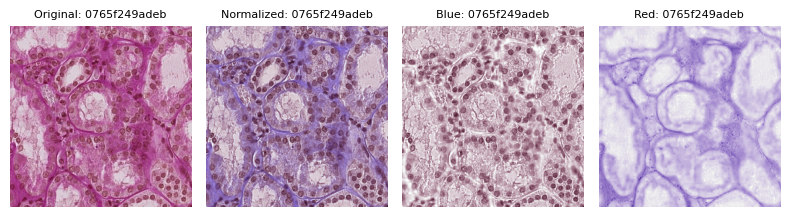

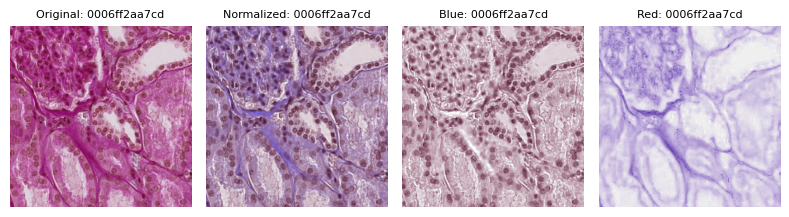

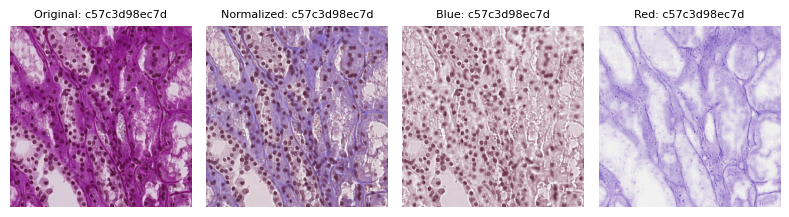

In [9]:

for _ in range(3):
  id = images_with_masks.id.sample().values[0]
  original_image_path = '/gdrive/MyDrive/DATA/HuBMAP/images/'
  norm_image_path = '/gdrive/MyDrive/DATA/HuBMAP/norm_images/'
  b_image_path = '/gdrive/MyDrive/DATA/HuBMAP/blue_images/'
  r_image_path = '/gdrive/MyDrive/DATA/HuBMAP/red_images/'

  o_img = cv2.imread(original_image_path + id + '.tif')
  n_img = cv2.imread(norm_image_path + id + '.tif')
  b_img = cv2.imread(b_image_path + id + '.tif')
  r_img = cv2.imread(r_image_path + id + '.tif')

  images = [o_img,n_img,b_img,r_img]
  titles = ['Original','Normalized','Blue','Red']

  plt.figure(figsize=(8,8))
  for idx,title in enumerate(titles):
    plt.subplot(1,4,idx+1)
    plt.imshow(images[idx])
    plt.title(title + ': ' + id,fontsize=8)
    plt.axis('off')
    plt.tight_layout()


In [10]:
# class for creating the dataset
class COCODataset:
    def __init__(self, images_dirpath: str, annotations_filepath: str, length: int = 1633):
        self.train_size = None
        self.val_size = None
        self.length = length
        self.classes = None
        self.labels_counter = None
        self.normalize = None

        self.images_dirpath = images_dirpath
        self.annotations_filepath = annotations_filepath
        self.dataset_dirpath = os.path.join(os.getcwd(), "dataset")
        self.train_dirpath =  os.path.join(self.dataset_dirpath, "train")
        self.val_dirpath =  os.path.join(self.dataset_dirpath, "val")
        self.config_path = os.path.join(self.dataset_dirpath, "coco.yaml")

        self.samples = self.parse_jsonl(annotations_filepath)
        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

    def __prepare_dirs(self) -> None:
        if not os.path.exists(self.dataset_dirpath):
            os.makedirs(os.path.join(self.train_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.train_dirpath, "labels"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "labels"), exist_ok=True)
        else:
            raise RuntimeError("Dataset already exists!")

    def __define_splitratio(self) -> None:
        self.train_size = round(self.length * self.train_size)
        self.val_size = self.length - self.train_size
        assert self.train_size + self.val_size == self.length

    def parse_jsonl(self, path: str) -> list[dict, ...]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons", total=self.length
                )
            ]
        return jsonl_samples

    def __define_paths(self, i: int) -> dict:
        data_path = self.val_dirpath
        if i < self.train_size:
            data_path = self.train_dirpath
        return {
            "images": os.path.join(data_path, "images"),
            "labels": os.path.join(data_path, "labels")
        }

    @staticmethod
    def __get_label_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["labels"],
            f"{identifier}.txt"
        )

    @staticmethod
    def __get_image_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["images"],
            f"{identifier}.tif"
        )

    def __copy_image(self, dst_path: str, identifier: str) -> str:
        shutil.copyfile(
            os.path.join(self.images_dirpath, f"{identifier}.tif"),
            dst_path
        )

    def __copy_label(self, annotations: list, dst_path: str) -> None:
        with open(dst_path, "w") as file:
            for annotation in annotations:
                coordinates = annotation["coordinates"][0]
                label = self.classes_dict[annotation["type"]]
                if label in self.classes:
                    if coordinates:
                        if self.normalize:
                            coordinates = np.array(coordinates) / 512.0
                        coordinates = " ".join(map(str, chain(*coordinates)))
                        file.write(f"{label} {coordinates}\n")
                        self.labels_counter += 1

    def __splitfolders(self):
        for i, line in tqdm(
                enumerate(self.samples),
                desc="Dataset creation", total=self.length
        ):
            self.labels_counter = 0
            identifier = line["id"]
            annotations = line["annotations"]
            paths_dict = self.__define_paths(i)

            dst_image_path = self.__get_image_path(paths_dict, identifier)
            dst_label_path = self.__get_label_path(paths_dict, identifier)

            self.__copy_image(dst_image_path, identifier)
            self.__copy_label(annotations, dst_label_path)

            if self.labels_counter == 0:
                os.remove(dst_image_path)
                os.remove(dst_label_path)

    def __count_dataset(self) -> dict:
        train_images = len(os.listdir(os.path.join(self.train_dirpath, "images")))
        train_labels = len(os.listdir(os.path.join(self.train_dirpath, "labels")))
        val_images = len(os.listdir(os.path.join(self.val_dirpath, "images")))
        val_labels = len(os.listdir(os.path.join(self.val_dirpath, "labels")))
        return {
            "train_images": train_images,
            "train_labels": train_labels,
            "val_images": val_images,
            "val_labels": val_labels
        }

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["train_images"] == count_dict["train_labels"]
        assert count_dict["val_images"] == count_dict["val_labels"]

    def __finalizing(self, count_dict: dict) -> None:
        assert os.path.exists(self.dataset_dirpath)

        example_structure = [
            "dataset",
            "train", "labels", "images",
            "val", "labels", "images"
        ]

        dir_bone = (
            dirname.split("/")[-1]
            for dirname, _, filenames in os.walk(self.dataset_dirpath)
            if dirname.split("/")[-1] in example_structure
        )

        try:
            print("\n~ HuBMAP Dataset Structure ~\n")
            print(
            f"""
          ├── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
            """
            )
        except StopIteration as e:
            print(e)
        else:
            print(Fore.GREEN + "-> Success")
            print(Fore.GREEN + f"Train dataset: {count_dict['train_images']}\nVal dataset: {count_dict['val_images']}")

    def get_config(self) ->dict:
        names = ["blood_vessel", "glomerulus", "unsure"]
        return {
            "train": str(self.train_dirpath),
            "val": str(self.val_dirpath),
            "names": [names[i] for i in self.classes]
        }

    @staticmethod
    def display_config(config: dict) -> None:
        print(Fore.BLACK + "\n~ HuBMAP Config Structure ~\n")
        print(
        f"""
      │   │
      │   ├── train
      │   │   └── {config['train']}/images
      │   │
      │   │
      │   ├── val
      │   │   └── {config['val']}/images
      │   │
      │   │
      │   ├── names
      │   │   └── {' '.join(config['names'])}
        """
        )
        print(Fore.GREEN + "-> Success")
        print(Fore.GREEN + f"Number of classes: {len(config['names'])}"
                           f"\nClasses: {' '.join(config['names'])}"
              )

    def write_config(self, config: dict) -> None:
        with open(self.config_path, mode="w") as f:
            yaml.safe_dump(stream=f, data=config)

    def __call__(self, train_size: float,
                 classes: list[int, ...],
                 make_config: bool = True,
                 normalize: bool = True
                ) -> None:

        self.train_size = train_size
        self.classes = classes
        self.normalize = normalize

        self.__define_splitratio()
        self.__prepare_dirs()
        self.__splitfolders()
        count_dict = self.__count_dataset()
        self.__check_sanity(count_dict)
        self.__finalizing(count_dict)

        if make_config:
            config = self.get_config()
            self.write_config(config)
            self.display_config(config)

In [11]:
!ls

sample_data


In [12]:
# instantiate a COCODataset object
path = '/gdrive/MyDrive/DATA/HuBMAP/'
coco = COCODataset(
    annotations_filepath= path + 'polygons.jsonl',
    images_dirpath=path + 'red_images/'
)

Processing polygons:   0%|          | 0/1633 [00:00<?, ?it/s]

In [13]:
coco(train_size=0.85, classes=[0, 1, 2])

Dataset creation:   0%|          | 0/1633 [00:00<?, ?it/s]


~ HuBMAP Dataset Structure ~


          ├── dataset
          │   │
          │   ├── train
          │   │   └── images
          │   │   └── labels
          │   │
          │   ├── val
          │   │   └── images
          │   │   └── labels
            
-> Success
Train dataset: 1388
Val dataset: 245

~ HuBMAP Config Structure ~


      │   │
      │   ├── train
      │   │   └── /content/dataset/train/images
      │   │
      │   │
      │   ├── val
      │   │   └── /content/dataset/val/images
      │   │
      │   │
      │   ├── names
      │   │   └── blood_vessel glomerulus unsure
        
-> Success
Number of classes: 3
Classes: blood_vessel glomerulus unsure


In [14]:
#files.download('/content/dataset/coco.yaml')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
#!zip -r '/content/dataset.zip' '/content/dataset'

In [18]:
#files.download('/content/dataset.zip')

In [ ]:
#!mkdir /gdrive/MyDrive/DATA/HuBMAP/dataset_coco_red

In [ ]:
#!cp -r dataset/ /gdrive/MyDrive/DATA/HuBMAP/dataset_coco_red/


<div class="alert alert-block alert-info" style="font-size:20px; background-color: #f2ffb0; font-family:verdana; color: #3c450e; border: 2px #3c450e solid">
    <b>And how can I use the right tools if the internet is banned in the competition? 🙁</b>
    <br>In the competition, many have difficulty installing the necessary tools and using them, because the Internet is prohibited, but it is prohibited only so that the test data is not stolen (they are uploaded to the test folder during the submission of the result). This means that you can use the tools you want, but you must add them as data. You can find my <b>ultralytics</b> and <b>pycocotools</b> dataset here. Importantly, the Internet is still present in this notebook to load the model, however, after training it, you will save the model, add it to the data and easily use it for forecasting without the Internet.<br>
</div>

In [14]:
!pip install ultralytics
display.clear_output()

In [15]:
pip show ultralytics

Name: ultralytics
Version: 8.0.132
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, opencv-python, pandas, Pillow, psutil, PyYAML, requests, scipy, seaborn, torch, torchvision, tqdm
Required-by: 


In [16]:
!pip install pycocotools
display.clear_output()

In [17]:
pip show pycocotools

Name: pycocotools
Version: 2.0.6
Summary: Official APIs for the MS-COCO dataset
Home-page: https://github.com/ppwwyyxx/cocoapi
Author: 
Author-email: 
License: FreeBSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy
Required-by: 


In [18]:
from pycocotools import _mask as coco_mask
import ultralytics
from ultralytics import YOLO

In [19]:
ultralytics.checks()

Ultralytics YOLOv8.0.132 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 26.8/166.8 GB disk)


In [20]:
!nvidia-smi

Wed Jul 12 03:40:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    42W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Train reference
# https://docs.ultralytics.com/modes/train/

In [21]:
!ls dataset


coco.yaml  train  val


In [25]:
def main():
    model = YOLO("yolov8x-seg.pt")
    model.train(
        # Project
        project="HuBMAP",
        name="yolov8x-seg",

        # Random Seed parameters
        deterministic=True,
        seed=43,

        # Data & model parameters
        data="/content/dataset/coco.yaml",
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=512,

        # Training parameters
        epochs=40,
        batch=4,
        workers=8,
        val=True,
        device= 0,

        # Optimization parameters
        lr0=0.018,
        patience=10,
        optimizer="SGD",
        momentum=0.947,
        weight_decay=0.0005,
        close_mosaic=3,
    )

In [26]:
if __name__ == '__main__':
    main()


Ultralytics YOLOv8.0.132 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/content/dataset/coco.yaml, epochs=40, patience=10, batch=4, imgsz=512, save=True, save_period=5, cache=False, device=0, workers=8, project=HuBMAP, name=yolov8x-seg, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=3, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fals

In [27]:
files.download('/content/HuBMAP/yolov8x-seg2/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import matplotlib.pyplot as plt
from PIL import Image

In [29]:
dirlist = os.listdir("/content/dataset/val/images")
print(dirlist[:5])

['f66cf535672b.tif', 'dccfd5b60684.tif', 'f21ab98d3572.tif', 'f64540767eee.tif', 'e2149f3ab975.tif']



image 1/1 /content/dataset/val/images/ed6a92a9410c.tif: 512x512 9 blood_vessels, 2 glomeruluss, 17.7ms
Speed: 1.3ms preprocess, 17.7ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 512)


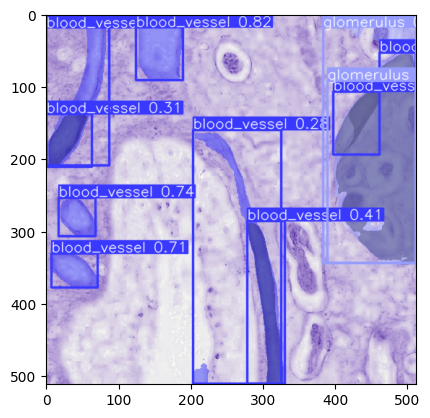

In [30]:
model = YOLO("/content/HuBMAP/yolov8x-seg/weights/best.pt")
history = model.predict("/content/dataset/val/images/ed6a92a9410c.tif")[0]
image = history.plot()
plt.imshow(image)
plt.show()

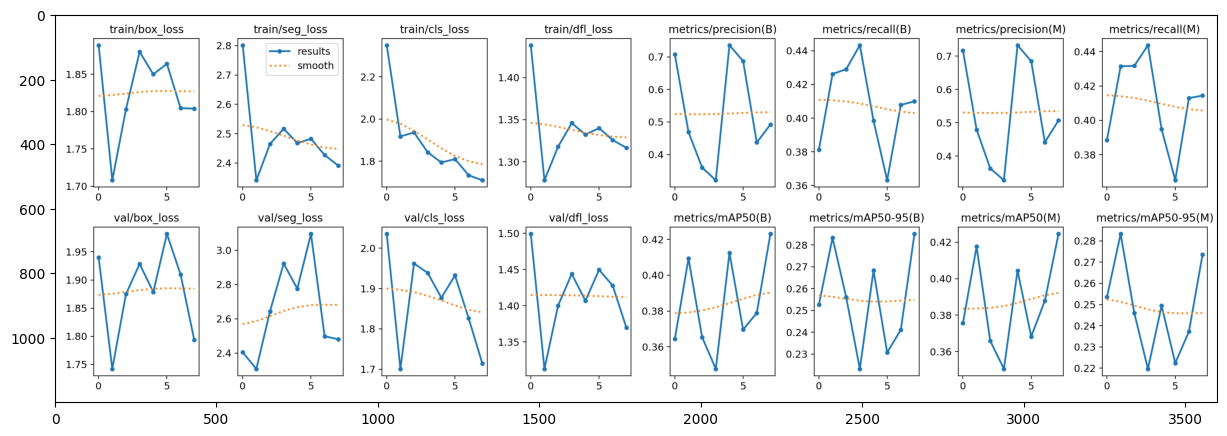

In [31]:
F1_curve = Image.open("/content/HuBMAP/yolov8x-seg/results.png")
plt.figure(figsize=(15,20))
plt.imshow(F1_curve)
plt.show()


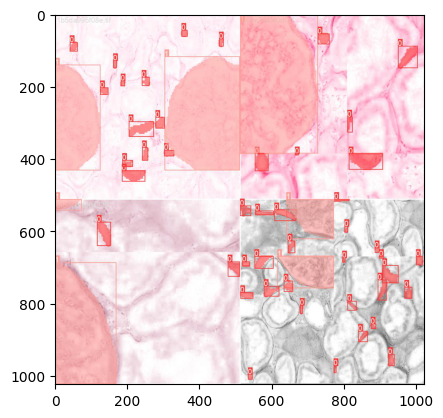

In [32]:
P_curve = Image.open("/content/HuBMAP/yolov8x-seg/train_batch1.jpg")
plt.imshow(P_curve)
plt.show()

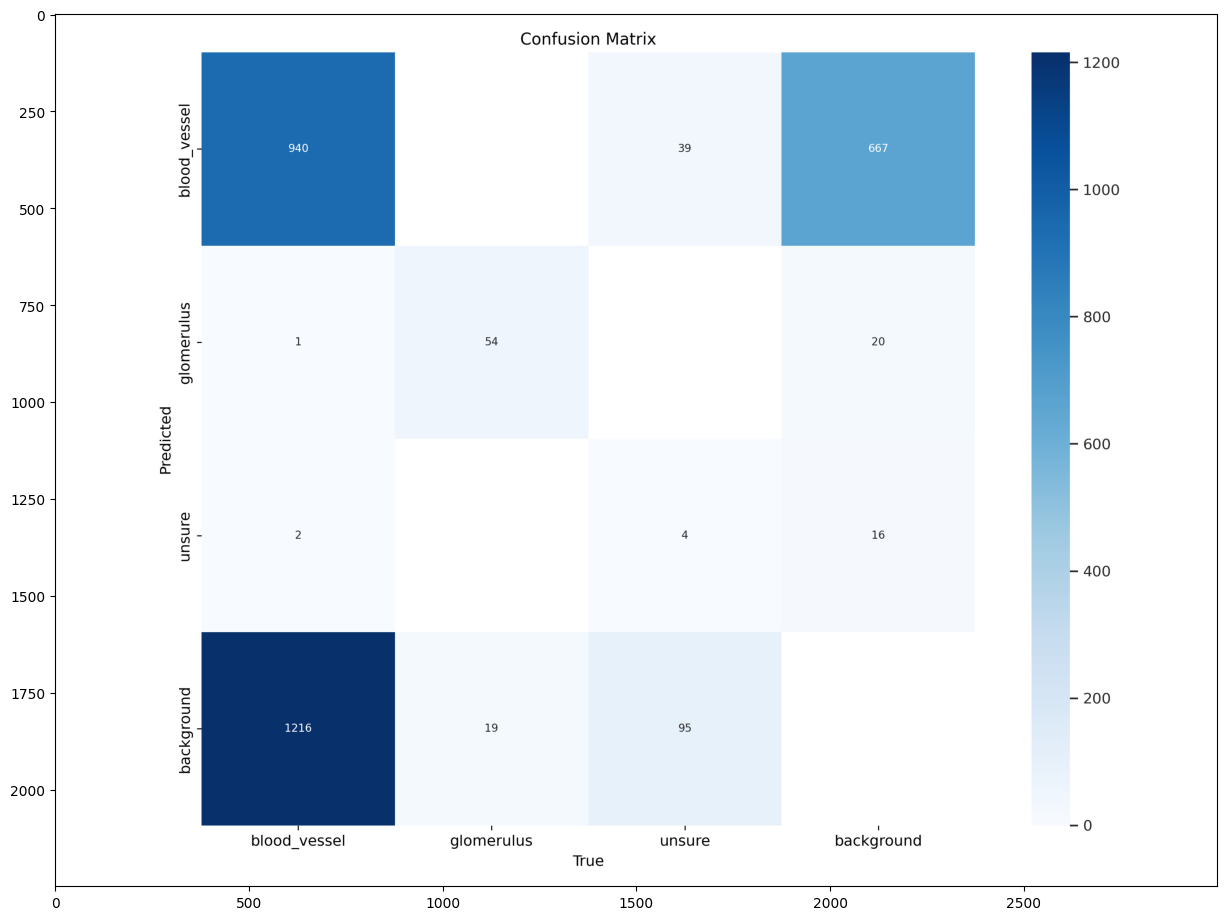

In [34]:
plt.figure(figsize=(15,20))
confusion_matrix = Image.open("/content/HuBMAP/yolov8x-seg/confusion_matrix.png")
plt.imshow(confusion_matrix)
plt.show()


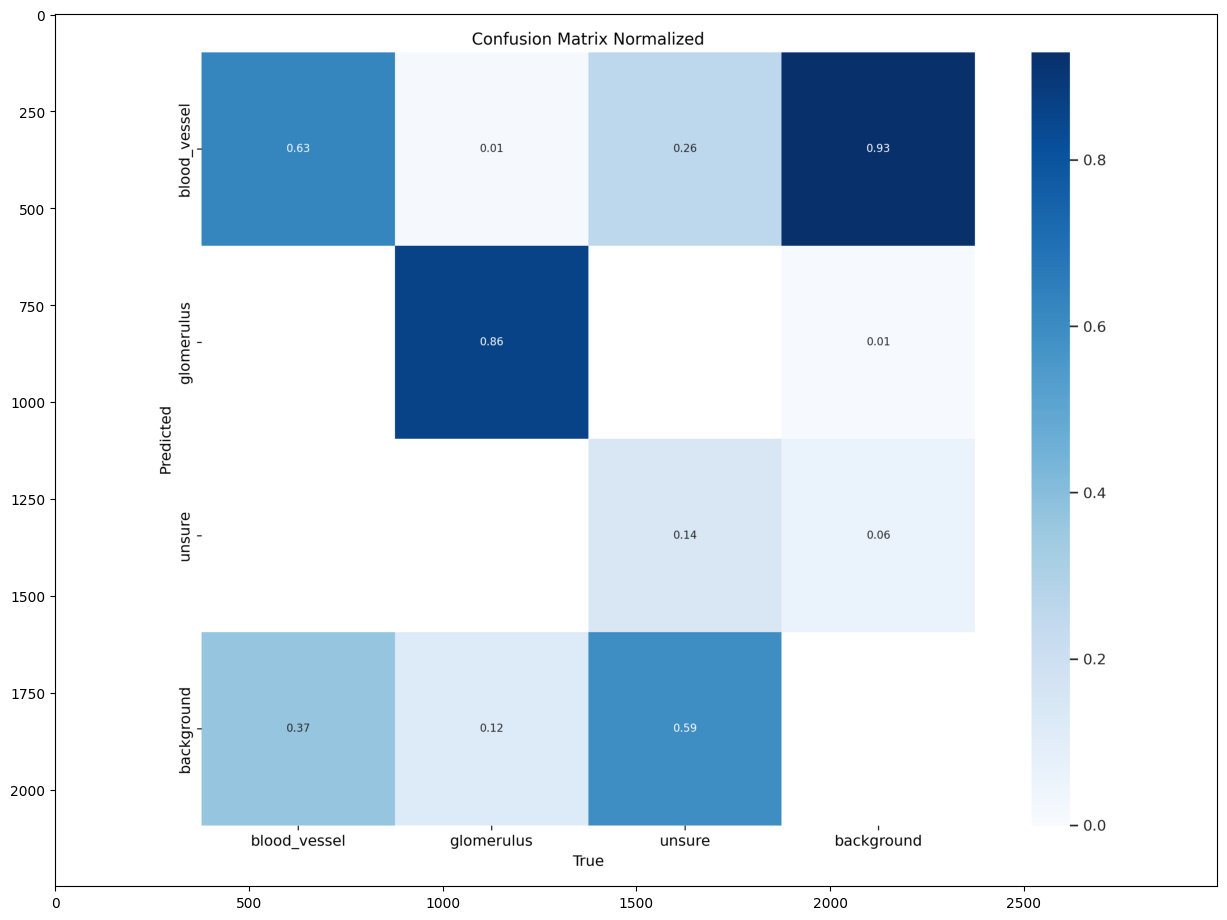

In [35]:
plt.figure(figsize=(15,20))
confusion_matrix = Image.open("/content/HuBMAP/yolov8x-seg2/confusion_matrix_normalized.png")
plt.imshow(confusion_matrix)
plt.show()